In [2]:
# Import necessary libraries
from fastai.basics import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.all import *

from fastai.metrics import *
from fastai.callback.wandb import *
import wandb

In [45]:
eval_results = []

/scratch/rc4499/masked/pneumonia_clean/none


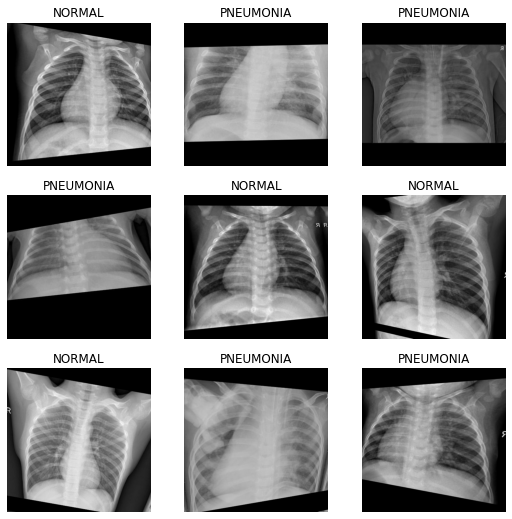

In [51]:
eval_data_root = Path("/scratch/rc4499/masked")

DS_NAMES=["chexpert_pn_clean", "pneumonia_clean"]
VARIATIONS=["none", "raw", "convex_hull", "crop"]

orig_ds = DS_NAMES[1]
new_ds = DS_NAMES[1]
orig_var = VARIATIONS[0]
new_var = VARIATIONS[0]

# for orig_ds in DS_NAMES:
#     for orig_var in VARIATIONS
# Load the data
data_path = eval_data_root/new_ds/new_var
print(data_path)

# def nosplit(o): return L(int(i) for i in range(len(o))), L()
def nosplit(o): return L(int(i) for i in range(len(o))), L(int(i) for i in range(len(o)))

dls = ImageDataLoaders.from_folder(data_path, train="train", valid="val",
        bs=32, num_workers=2, 
        splitter=nosplit,
        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
        item_tfms=None)

dls.show_batch()

In [47]:
learn = cnn_learner(dls, models.resnet50, metrics = [accuracy, 
                    F1Score(), 
                    RocAucBinary(),
                    Precision(),
                    Recall()], cbs=None)

In [55]:
orig_ys = np.array([0, 0])
# orig_ys = {"nih":0, "chexpert":0}
for item in dls.train_ds:
    y = item[1]
    val = y.item()
    orig_ys[val] += 1

print(orig_ys)

for item in dls.valid_ds:
    y = item[1]
    val = y.item()
    orig_ys[val] += 1
    
print(orig_ys)

[859 954]
[1074 1193]


In [34]:
model_pth = f"/home/rc4499/final/models/{orig_ds}_{orig_var}"
learn.load(model_pth)

In [36]:
# print("valid_loss	accuracy	f1_score	roc_auc_score")
# res = learn.validate(dl=dls.train)
res = learn.validate()
res

(#6) [0.39791008830070496,0.8338761925697327,0.6817472698907956,0.8683523596826705,0.7803571428571429,0.6052631578947368]

In [37]:
params = [orig_ds, orig_var, new_ds, new_var]
params.extend(res)
eval_results.append(params)

['chexpert_pn_clean',
 'none',
 'chexpert_pn_clean',
 'none',
 0.39791008830070496,
 0.8338761925697327,
 0.6817472698907956,
 0.8683523596826705,
 0.7803571428571429,
 0.6052631578947368]

In [68]:
eval_results = []

eval_split = ["train", "valid"]

num_iter = len(DS_NAMES)**2 * len(VARIATIONS)**2

i = 0

for orig_ds in DS_NAMES:
    for orig_var in VARIATIONS:
        for new_ds in DS_NAMES:
            for new_var in VARIATIONS:
                # Load the eval data
                data_path = eval_data_root/new_ds/new_var
                # print(data_path)

                dls = ImageDataLoaders.from_folder(data_path, train="train", valid="val",
                        bs=32, num_workers=2, 
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                        item_tfms=None)
                
                learn = cnn_learner(dls, models.resnet50, metrics = [accuracy, 
                    F1Score(), 
                    RocAucBinary(),
                    Precision(),
                    Recall()], cbs=None)
                
                model_pth = f"/home/rc4499/final/models/{orig_ds}_{orig_var}"
                learn.load(model_pth)
                
                i+=1
                print(f"Iteration {i}/{num_iter}")

                
                for split in eval_split:
                    if split == "train":
                        my_dl = dls.train
                    elif split == "valid":
                        my_dl = dls.valid
                    else:
                        raise Exception()
                        
                    res = learn.validate(dl=my_dl)

                    params = [orig_ds, orig_var, new_ds, new_var, split]
                    params.extend(res)
                    eval_results.append(params)

Iteration 1/64


Iteration 2/64


Iteration 3/64


Iteration 4/64


Iteration 5/64


Iteration 6/64


Iteration 7/64


Iteration 8/64


Iteration 9/64


Iteration 10/64


Iteration 11/64


Iteration 12/64


Iteration 13/64


Iteration 14/64


Iteration 15/64


Iteration 16/64


Iteration 17/64


Iteration 18/64


Iteration 19/64


Iteration 20/64


Iteration 21/64


Iteration 22/64


Iteration 23/64


Iteration 24/64


Iteration 25/64


Iteration 26/64


Iteration 27/64


Iteration 28/64


Iteration 29/64


Iteration 30/64


Iteration 31/64


Iteration 32/64


Iteration 33/64


Iteration 34/64


Iteration 35/64


Iteration 36/64


Iteration 37/64


Iteration 38/64


Iteration 39/64


Iteration 40/64


Iteration 41/64


Iteration 42/64


Iteration 43/64


Iteration 44/64


Iteration 45/64


Iteration 46/64


Iteration 47/64


Iteration 48/64


Iteration 49/64


Iteration 50/64


Iteration 51/64


Iteration 52/64


Iteration 53/64


Iteration 54/64


Iteration 55/64


Iteration 56/64


Iteration 57/64


Iteration 58/64


Iteration 59/64


Iteration 60/64


Iteration 61/64


Iteration 62/64


Iteration 63/64


Iteration 64/64


In [70]:
df = pd.DataFrame(eval_results, columns=[
 "model_ds", "model_var", "eval_ds", "eval_var", "split", "valid_loss", "accuracy", "F1Score", "RocAuc", "Precision", "Recall"
])
df

,model_ds,model_var,eval_ds,eval_var,split,valid_loss,accuracy,F1Score,RocAuc,Precision,Recall
0,chexpert_pn_clean,none,chexpert_pn_clean,none,train,0.389414,0.831230,0.703929,0.882811,0.760417,0.655253
1,chexpert_pn_clean,none,chexpert_pn_clean,none,valid,0.397910,0.833876,0.681747,0.868352,0.780357,0.605263
2,chexpert_pn_clean,none,chexpert_pn_clean,raw,train,1.157573,0.392610,0.494793,0.733030,0.331932,0.971410
3,chexpert_pn_clean,none,chexpert_pn_clean,raw,valid,1.284948,0.338355,0.467038,0.738297,0.305973,0.986150
4,chexpert_pn_clean,none,chexpert_pn_clean,convex_hull,train,0.601141,0.708774,0.635216,0.831804,0.515202,0.828125
...,...,...,...,...,...,...,...,...,...,...,...
123,pneumonia_clean,crop,pneumonia_clean,raw,valid,2.619959,0.581498,0.686469,0.612221,0.566757,0.870293
124,pneumonia_clean,crop,pneumonia_clean,convex_hull,train,1.161632,0.622210,0.644992,0.674070,0.636646,0.653560
125,pneumonia_clean,crop,pneumonia_clean,convex_hull,valid,1.481065,0.546256,0.662295,0.628248,0.544474,0.845188
126,pneumonia_clean,crop,pneumonia_clean,crop,train,0.419277,0.838728,0.844874,0.903047,0.851732,0.838126


In [71]:
df.to_csv("eval_results.csv", index=False)